In [ ]:
# pip install transformers

In [ ]:
# pip install emoji

### 1. Import packages

In [3]:
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader
from transformers import AdamW
import pandas as pd
import torch
import random
import emoji
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import json
from collections import Counter
import re
import os
from string import punctuation
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

In [4]:
SEED = 9999
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda', index=0)

### 2. Load and clean data

In [5]:
def remove_punct(s):
    punct_pattern = re.compile(r'[^\w\s\#]')
    no_punct = punct_pattern.sub(r'', s)
    return no_punct

In [6]:
def remove_emoji(string):
    allchars = [str for str in string]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI['en']]
    clean_text = ' '.join([str for str in string.split() if not any(i in str for i in emoji_list)])
    return clean_text

In [7]:
def read_data(data, test=False):
    texts = []
    labels = []
    if test == False:
        data.dropna(subset=['tidyTweet', 'Label'], inplace=True)
    else:
        data.dropna(subset=['tidyTweet'], inplace=True)

    for i in tqdm(data.itertuples(), total=len(data)):
        line = getattr(i, 'tidyTweet')
        line = line.strip()
        if not line:
            continue
        line = remove_emoji(line)
        line = remove_punct(line).strip()
        texts.append(line)

        if test == False:
            label = getattr(i, 'Label')
            labels.append(label)
            if label == 1.0:
                texts.extend([line] * 2)
                labels.extend([label] * 2)

    if test == False:
        assert len(texts) == len(labels)
        return texts, labels
    else:
        return texts

In [8]:
df = pd.read_csv('../dataset.csv')
df.groupby(['Label']).count()

,id,date,tweet,tidyTweet
Label,,,,
0.0,8865,8865,8865,8864
1.0,2884,2884,2884,2883


In [9]:
texts, labels = read_data(df)

  0%|          | 0/11747 [00:00<?, ?it/s]

In [10]:
Counter(labels)

Counter({0.0: 8864, 1.0: 8649})

### 3. Split train validation dataset

In [11]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels,
                                                                    test_size=0.2,
                                                                    random_state=43,
                                                                    stratify=labels)

In [12]:
len(train_labels),len(val_labels),len(train_texts),len(val_texts)

(14010, 3503, 14010, 3503)

In [13]:
max([len(item) for item in texts])

286

### 4. Tokenization

In [14]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
train_encodings = tokenizer(train_texts,
                            truncation=True,
                            padding='max_length',
                            max_length=128)
val_encodings = tokenizer(val_texts,
                          truncation=True,
                          padding='max_length',
                          max_length=128)

In [16]:
label_ids = {item: idx for idx, item in enumerate(set(sorted(labels)))}
label_ids

{0.0: 0, 1.0: 1}

### 5. Generate dataset

In [17]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        idx = int(idx)
        item = {
            key: torch.tensor(val[idx])
            for key, val in self.encodings.items()
        }
        if self.labels is not None:
            item['labels'] = torch.tensor(label_ids[self.labels[idx]])
        return item

    def __len__(self):
        return len(self.encodings.input_ids)

In [18]:
train_dataset = Dataset(train_encodings, train_labels)
val_dataset = Dataset(val_encodings, val_labels)

### 6. Dataloader

In [19]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
eval_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### 7. Load pretrained model

In [20]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=len(label_ids))
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

### 8. Evaluation

In [21]:
@torch.no_grad()
def eval_model(model, eval_loader):
    model.eval()
    labels = []
    preds = []
    eval_loss = 0
    for batch in eval_loader:
        batch_input_ids = batch['input_ids'].to(device)
        batch_labels = batch['labels'].to(device)
        outputs = model(input_ids=batch_input_ids, labels=batch_labels)
        eval_loss += outputs.loss.item()
        labels.extend(batch_labels.cpu().numpy())
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

    eval_loss = eval_loss / len(val_dataset)
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')
    return accuracy, precision, recall, f1, eval_loss

### 9. Train the model

In [22]:
epoch = 4
lr = 5e-5
# path = './model_best_bert/e{}_bs{}_lr{:.0e}'.format(epoch, batch_size, lr)
path = './model_best_bert'
best_acc = 0
# train_losses = []
train_stats = {'Epoch':[], 'Loss':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}
eval_stats = {'Epoch':[], 'Loss':[], 'Accuracy':[], 'Precision':[], 'Recall':[], 'F1':[]}

param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [{'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.01}, 
                                {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
                                 'weight_decay_rate': 0.0}]

optim = AdamW(optimizer_grouped_parameters, lr=lr)
writer = SummaryWriter(comment='-bert-ep{}-bs{}-lr{}'.format(epoch, batch_size, lr))

for e in tqdm(range(epoch), desc='Epoch'):
    model.train()
    labels = []
    preds = []
    train_loss = 0
    for idx, batch in tqdm(enumerate(train_loader),
                           total=len(train_texts) // batch_size,
                           desc='Batch'):
        optim.zero_grad()
        batch_input_ids = batch['input_ids'].to(device)
        batch_labels = batch['labels'].to(device)
        outputs = model(input_ids=batch_input_ids, labels=batch_labels)
        loss = outputs.loss
        train_loss += loss.item()
        labels.extend(batch_labels.cpu().numpy())
        preds.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())
        loss.backward()
        optim.step()
    
    train_loss = train_loss / len(train_dataset)
    # train_losses.append(train_loss)

    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='macro')
    recall = recall_score(labels, preds, average='macro')
    f1 = f1_score(labels, preds, average='macro')

    e_accuracy, e_precision, e_recall, e_f1, eval_loss = eval_model(model, eval_loader)

    train_stats['Epoch'].append(e)
    train_stats['Loss'].append(train_loss)
    train_stats['Accuracy'].append(accuracy)
    train_stats['Precision'].append(precision)
    train_stats['Recall'].append(recall)
    train_stats['F1'].append(f1)

    eval_stats['Epoch'].append(e)
    eval_stats['Loss'].append(eval_loss)
    eval_stats['Accuracy'].append(e_accuracy)
    eval_stats['Precision'].append(e_precision)
    eval_stats['Recall'].append(e_recall)
    eval_stats['F1'].append(e_f1)

    writer.add_scalar('Train Loss', train_loss, e)
    writer.add_scalar('Train Accuracy', accuracy, e)
    writer.add_scalar('Train Precision', precision, e)
    writer.add_scalar('Train Recall', recall, e)
    writer.add_scalar('Train F1', f1, e)

    writer.add_scalar('Val Loss', eval_loss, e)
    writer.add_scalar('Val Accuracy', e_accuracy, e)
    writer.add_scalar('Val Precision', e_precision, e)
    writer.add_scalar('Val Recall', e_recall, e)
    writer.add_scalar('Val F1', e_f1, e)

    print(f'Epoch:{e+1}/{epoch}')
    print()

    print('Train loss:', train_loss)
    print('Train Accuracy:', accuracy)
    print('Train Precision:', precision)
    print('Train Recall:', recall)
    print('Train F1:', f1)
    print()

    print('Val Loss:', eval_loss)
    print('Val Accuracy:', e_accuracy)
    print('Val Precision:', e_precision)
    print('Val Recall:', e_recall)
    print('Val F1:', e_f1)
    print()

    if e_accuracy > best_acc:
        model.save_pretrained(path)  
        tokenizer.save_pretrained(path)
        best_acc = e_accuracy

print('Best Val Accuracy:', best_acc)
print('Finished Training.')

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:1/4

Train loss: 0.01845677973201324
Train Accuracy: 0.6781584582441114
Train Precision: 0.6782918787350651
Train Recall: 0.6778811934435882
Train F1: 0.6778507375782762

Val Loss: 0.016667661252036763
Val Accuracy: 0.7422209534684556
Val Precision: 0.765423343185361
Val Recall: 0.7403701638906005
Val F1: 0.7354603325854289



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:2/4

Train loss: 0.011298707790731277
Train Accuracy: 0.8503211991434689
Train Precision: 0.8502954004864796
Train Recall: 0.8503310635881335
Train F1: 0.8503072998767591

Val Loss: 0.01111131665742707
Val Accuracy: 0.848986582928918
Val Precision: 0.8567346748834952
Val Recall: 0.8498925761828846
Val F1: 0.8483776226351026



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:3/4

Train loss: 0.004991487904101461
Train Accuracy: 0.9449678800856531
Train Precision: 0.9449471944681891
Train Recall: 0.9449990235949239
Train F1: 0.9449633575385061

Val Loss: 0.010619418302621631
Val Accuracy: 0.8892377961747074
Val Precision: 0.8961688868579906
Val Recall: 0.8900622373495821
Val F1: 0.8888863818446395



Batch:   0%|          | 0/437 [00:00<?, ?it/s]

Epoch:4/4

Train loss: 0.0023264695784717872
Train Accuracy: 0.9765881513204854
Train Precision: 0.9765699972940893
Train Recall: 0.9766091621384577
Train F1: 0.9765856777157395

Val Loss: 0.012160221863162627
Val Accuracy: 0.8875249785897802
Val Precision: 0.9000275182560138
Val Recall: 0.8886225299857529
Val F1: 0.8868275078505112

Best Val Accuracy: 0.8892377961747074
Finished Training.


In [23]:
train_stats

{'Accuracy': [0.6781584582441114,
  0.8503211991434689,
  0.9449678800856531,
  0.9765881513204854],
 'Epoch': [0, 1, 2, 3],
 'F1': [0.6778507375782762,
  0.8503072998767591,
  0.9449633575385061,
  0.9765856777157395],
 'Loss': [0.01845677973201324,
  0.011298707790731277,
  0.004991487904101461,
  0.0023264695784717872],
 'Precision': [0.6782918787350651,
  0.8502954004864796,
  0.9449471944681891,
  0.9765699972940893],
 'Recall': [0.6778811934435882,
  0.8503310635881335,
  0.9449990235949239,
  0.9766091621384577]}

In [24]:
eval_stats

{'Accuracy': [0.7422209534684556,
  0.848986582928918,
  0.8892377961747074,
  0.8875249785897802],
 'Epoch': [0, 1, 2, 3],
 'F1': [0.7354603325854289,
  0.8483776226351026,
  0.8888863818446395,
  0.8868275078505112],
 'Loss': [0.016667661252036763,
  0.01111131665742707,
  0.010619418302621631,
  0.012160221863162627],
 'Precision': [0.765423343185361,
  0.8567346748834952,
  0.8961688868579906,
  0.9000275182560138],
 'Recall': [0.7403701638906005,
  0.8498925761828846,
  0.8900622373495821,
  0.8886225299857529]}

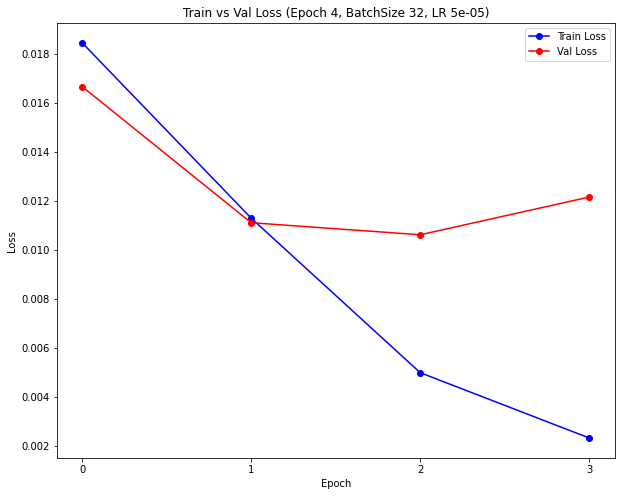

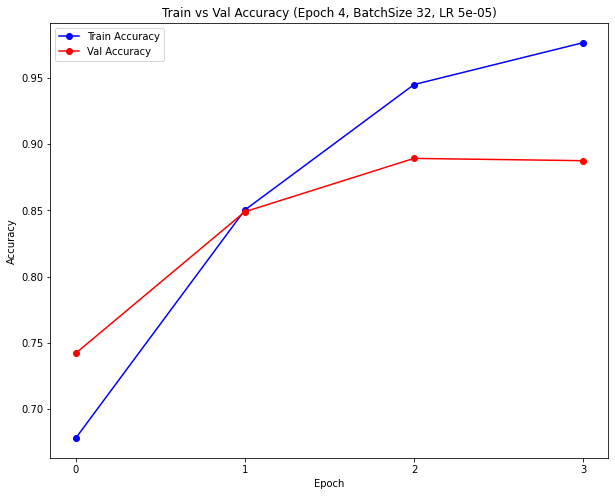

In [39]:
plt.figure(figsize=(10, 8))
plt.plot(train_stats['Loss'], label='Train Loss', marker='o', color='b')
plt.plot(eval_stats['Loss'], label='Val Loss', marker='o', color='r')
plt.title('Train vs Val Loss (Epoch {}, BatchSize {}, LR {:.0e})'.format(epoch, batch_size, lr))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(eval_stats['Epoch'])
plt.legend()
plt.savefig(path+'/BERT_loss.png')
plt.show()

plt.figure(figsize=(10, 8))
plt.plot(train_stats['Accuracy'], label='Train Accuracy', marker='o', color='b')
plt.plot(eval_stats['Accuracy'], label='Val Accuracy', marker='o', color='r')
plt.title('Train vs Val Accuracy (Epoch {}, BatchSize {}, LR {:.0e})'.format(epoch, batch_size, lr))
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(eval_stats['Epoch'])
plt.legend()
plt.savefig(path+'/BERT_accuracy.png')
plt.show()

In [26]:
# output training results
if not os.path.exists(path):
    os.makedirs(path)

f = open(f'{path}/train_stats_e{epoch}_bs{batch_size}_lr{lr:.0e}', 'w+')
f.write(json.dumps(train_stats))
f.close()
f = open(f'{path}/eval_stats_e{epoch}_bs{batch_size}_lr{lr:.0e}', 'w+')
f.write(json.dumps(eval_stats))
f.close()

### 10. Prediction of test dataset

In [ ]:
trained_bert_model = BertForSequenceClassification.from_pretrained(path)
trained_bert_tokenizer = BertTokenizer.from_pretrained(path)
trained_bert_model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
def test_model(test_data, model, tokenizer):
    for data in test_data:
        print(data)
        test_df = pd.read_csv('../' + data)
        test_texts = read_data(test_df, test=True)
        test_encodings = tokenizer(test_texts,
                                truncation=True,
                                padding='max_length',
                                max_length=128)
        test_dataset = Dataset(test_encodings)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        model.eval()
        test_predictions = []
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            with torch.no_grad():
                outputs = model(input_ids)
            test_predictions.extend(torch.argmax(outputs.logits, dim=-1).cpu().numpy())

        test_pred_uniq = np.unique(test_predictions, return_counts=True)
        for l in test_pred_uniq[0]:
            print('Test Label:', l)
            print('Count:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item())
            print('Percentage:', test_pred_uniq[1][np.where(test_pred_uniq[0]==l)].item() / np.sum(test_pred_uniq[1]))
        test_df_labeled = pd.concat((test_df, pd.Series(test_predictions, name='label')), axis=1)
        test_df_labeled.to_csv(path + '/' + data.split('.')[0] + '_labeled.csv', index=False)
        # print(test_df_labeled.head())
        print()

In [ ]:
test_data = ['test_truckers_data.csv', 'test_covid_data.csv']
test_model(test_data, trained_bert_model, trained_bert_tokenizer)

test_truckers_data.csv


  0%|          | 0/1803 [00:00<?, ?it/s]

Test Label: 0
Count: 1692
Percentage: 0.9384359400998337
Test Label: 1
Count: 111
Percentage: 0.06156405990016639

test_covid_data.csv


  0%|          | 0/1954 [00:00<?, ?it/s]

Test Label: 0
Count: 1618
Percentage: 0.8280450358239508
Test Label: 1
Count: 336
Percentage: 0.17195496417604914



In [ ]:
# # download trained model and dataset for google colab
# from google.colab import files
# files.download('/content'+ path.split('.')[1] + '/test_covid_data_labeled.csv')
# files.download('/content'+ path.split('.')[1] + '/test_truckers_data_labeled.csv')
# !zip -r /content/model_best_bert.zip /content/model_best_bert
# files.download("/content/model_best_bert.zip")